# Imports and Settings

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV


from sklearn.metrics import * 

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 5)

# Preprocessing Data For Algorithms
### Choosing Features:
From the `Exploratory Data Analysis`, it was discovered that most of the trends in the data with respect to flight arrival delays had to do with the amount of traffic occuring during the time of the flight. 
- Apart from that the `hour` of the flight had information on the chances of a delay that was not completely congruent with the amount of traffic.

Appropriately, the features I have decided to use for the algorithms are time based. Since the time of a flight should be an excellent indicator of how much relative traffic one can expect, for a given period.

### Features:
Data:
- Month
- Week
- Day
- Day of Week
- Hour

Target:
- Whether the flight delay is greater than 0
  - 1 (True) would indicate a delayed flight
  - 0 (False) would indicate a flight that was on time or early

### Evaluation:
1. Algorithm Spot-checking
    - several classification algorithms will be tested, with `cross validation`
    - The top two best performing algorithms will be chosen taken to the next round, where their hyperparameters will be tuned with `GridSearchCV`
    
2. Evaluation: 
  - The cross validation will occur across several common metrics
  - However, the metic of `focus` will be `Recall` because False Negative are more expensive in the case of predicting flight delays
  - Grid Search will be applied for hyperparameter tunning 


### Import and Process Data

In [3]:
df = pd.read_csv('flights_sample.csv', sep=';')

In [4]:
df = df[['fl_date', 'crs_dep_time', 'arr_delay']].copy(deep=True)

In [5]:
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')
df['month'] =  df.fl_date.dt.month
df['week'] = df.fl_date.dt.isocalendar().week
df['day'] = df.fl_date.dt.dayofyear
df['day_of_week'] = df.fl_date.dt.dayofweek
df['hour'] = pd.cut(df['crs_dep_time'], bins=24)
df['delay_bool'] = df['arr_delay'] > 0

In [6]:
lb = LabelBinarizer()
df['delay_bool'] = lb.fit_transform(df['delay_bool'].values) 

In [7]:
df

,fl_date,crs_dep_time,arr_delay,month,week,day,day_of_week,hour,delay_bool
0,2019-05-22,1140,22.0,5,21,142,2,"(1081.75, 1180.0]",1
1,2018-08-28,800,-5.0,8,35,240,1,"(787.0, 885.25]",0
2,2018-01-14,1447,5.0,1,2,14,6,"(1376.5, 1474.75]",1
3,2018-02-20,1440,-20.0,2,8,51,1,"(1376.5, 1474.75]",0
4,2019-06-07,1150,-7.0,6,23,158,4,"(1081.75, 1180.0]",0
...,...,...,...,...,...,...,...,...,...
99991,2018-07-24,1300,NaN,7,30,205,1,"(1278.25, 1376.5]",0
99992,2019-02-04,1430,71.0,2,6,35,0,"(1376.5, 1474.75]",1
99993,2019-11-21,1510,56.0,11,47,325,3,"(1474.75, 1573.0]",1
99994,2018-10-16,1035,0.0,10,42,289,1,"(983.5, 1081.75]",0


In [8]:
df.delay_bool.value_counts()

0    65335
1    34661
Name: delay_bool, dtype: int64

In [9]:
X = df[['month', 'week', 'day', 'day_of_week', 'hour']].copy(deep=True)

le = LabelEncoder()
X['hour'] = le.fit_transform(X['hour'].astype(str))

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
y = df['delay_bool']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [12]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [13]:
y_test.value_counts()

0    16298
1     8701
Name: delay_bool, dtype: int64

In [14]:
pd.Series(y_sm).value_counts()

1    49037
0    49037
dtype: int64

In [15]:
def cv_plot(model, X=X_train, y=y_train, cv=10):
  """
  Runs a 5 fold cross validation on a model, and plots a bar graph for 
  the metrics {recalll, accuracy, precision, f1} representing each folds
  outcome.

  Takes [model] as an input: Which is the classification algorithm
  that has already been instantiated.

  Takes [X] and [y] as inputs for the data to predict on.

  Takes [cv] as an input: The number of cross validations to do
   """
  model_cv = cross_validate(model, X, y, cv=cv, verbose=0, scoring=['recall', 'accuracy', 'precision','f1'])
  
  display(pd.DataFrame(model_cv).drop(columns=['fit_time', 'score_time']))
  pd.DataFrame(model_cv).drop(columns=['fit_time', 'score_time']).plot.bar()
  plt.title(str(model))
  return None

# Systematic Search For Best Classification Algorithm
1. Linear Models:
  - Logistic Regression
  - Naive Bayes
2. Non-Linear Models:
  - Support Vector Machines
    - all kernels
3. Tree Based Models:
  - Random Forest Classifier
  - XGBoost

In each case the algorithms will be: 
- Trained and tested on the real data.
- Trained and tested on the synthetic data created through Synthetic Minority Oversampling Technique (SMOTE) to deal with the class imbalance
- Cross validated over 10 (5 for SVC) folds and plotting their scores for each fold

# Logistic Regression

## Basic Logistic Regression

In [ ]:
lg = LogisticRegression()

In [ ]:
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79     16340
           1       0.00      0.00      0.00      8659

    accuracy                           0.65     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.65      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.0,0.653200,0.0,0.0
1,0.0,0.653200,0.0,0.0
2,0.0,0.653333,0.0,0.0
3,0.0,0.653333,0.0,0.0
4,0.0,0.653333,0.0,0.0
5,0.0,0.653333,0.0,0.0
6,0.0,0.653333,0.0,0.0
7,0.0,0.653287,0.0,0.0
8,0.0,0.653287,0.0,0.0
9,0.0,0.653287,0.0,0.0


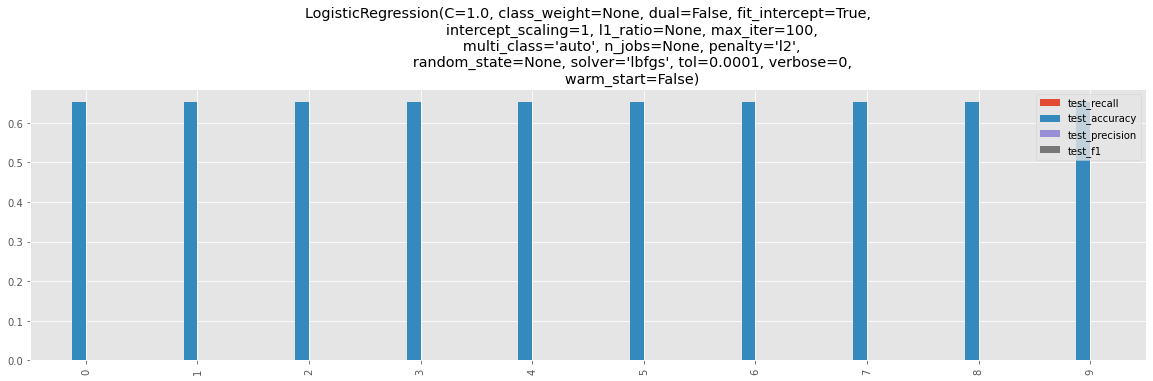

In [ ]:
cv_plot(lg)

## Logistic Regression with SMOTE

In [ ]:
Smote_lg = LogisticRegression()
Smote_lg.fit(X_sm, y_sm)
y_pred = Smote_lg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.46      0.56     16340
           1       0.39      0.64      0.48      8659

    accuracy                           0.52     24999
   macro avg       0.55      0.55      0.52     24999
weighted avg       0.60      0.52      0.53     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.644286,0.554138,0.545910,0.591032
1,0.629388,0.540259,0.534211,0.577907
2,0.631837,0.546280,0.539561,0.582064
3,0.641633,0.545362,0.538080,0.585311
4,0.622857,0.546484,0.540368,0.578688
5,0.639314,0.553322,0.545455,0.588666
6,0.636661,0.543117,0.536279,0.582175
7,0.637681,0.546790,0.539551,0.584526
8,0.632374,0.549138,0.542082,0.583757
9,0.642172,0.550770,0.542882,0.588367


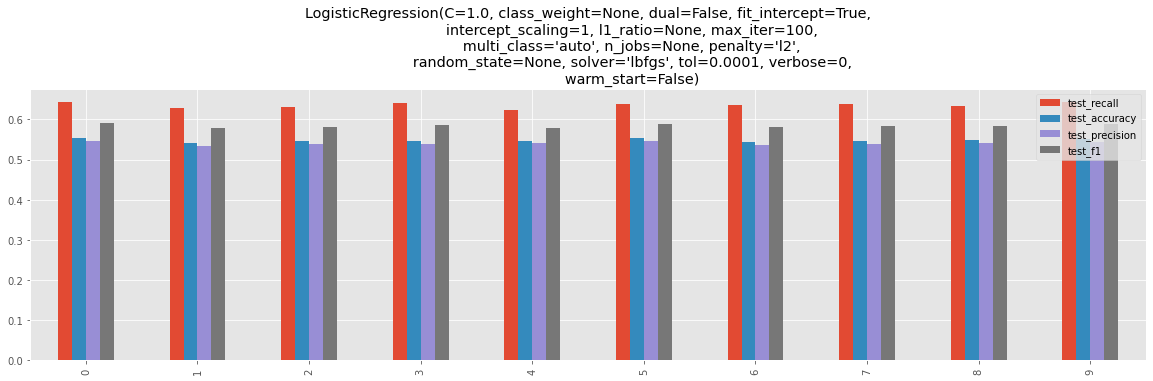

In [ ]:
cv_plot(Smote_lg, X_sm, y_sm )

# Naive Bayes

## Basic Naive Bayes

In [ ]:
X = df[['month', 'week', 'day', 'day_of_week', 'hour']].copy(deep=True)
# X['hour'] = le.fit_transform(X['hour'].astype(str))

In [ ]:
gnb  = GaussianNB()

In [ ]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79     16340
           1       0.00      0.00      0.00      8659

    accuracy                           0.65     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.65      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.0,0.653200,0.0,0.0
1,0.0,0.653200,0.0,0.0
2,0.0,0.653333,0.0,0.0
3,0.0,0.653333,0.0,0.0
4,0.0,0.653333,0.0,0.0
5,0.0,0.653333,0.0,0.0
6,0.0,0.653333,0.0,0.0
7,0.0,0.653287,0.0,0.0
8,0.0,0.653287,0.0,0.0
9,0.0,0.653287,0.0,0.0


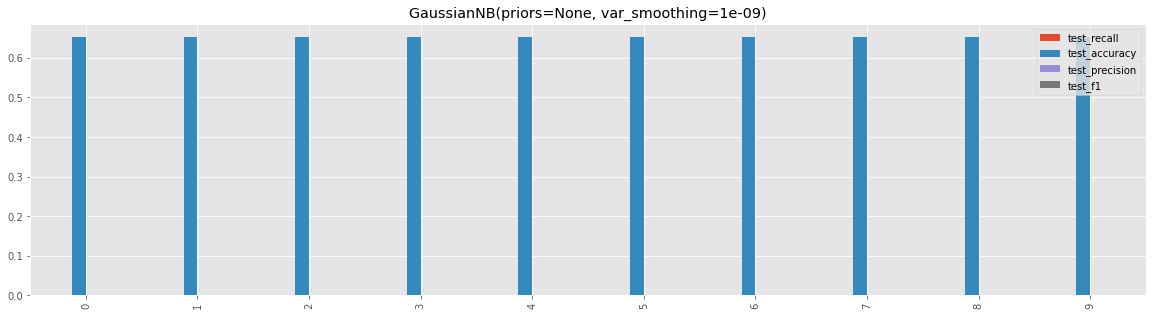

In [ ]:
cv_plot(gnb)

## Naive Bayes with SMOTE

In [ ]:
Smote_nb = GaussianNB()
Smote_nb.fit(X_sm, y_sm)
y_pred = Smote_nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54     16340
           1       0.39      0.68      0.50      8659

    accuracy                           0.52     24999
   macro avg       0.55      0.56      0.52     24999
weighted avg       0.61      0.52      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.682245,0.557812,0.546331,0.606770
1,0.675102,0.548015,0.538324,0.599004
2,0.688776,0.552914,0.541647,0.606415
3,0.682653,0.552403,0.541613,0.604009
4,0.675306,0.553934,0.543439,0.602239
5,0.691978,0.558935,0.546510,0.610701
6,0.677281,0.546790,0.537067,0.599079
7,0.673811,0.552607,0.542303,0.600947
8,0.680343,0.556587,0.545321,0.605395
9,0.689324,0.557710,0.545646,0.609127


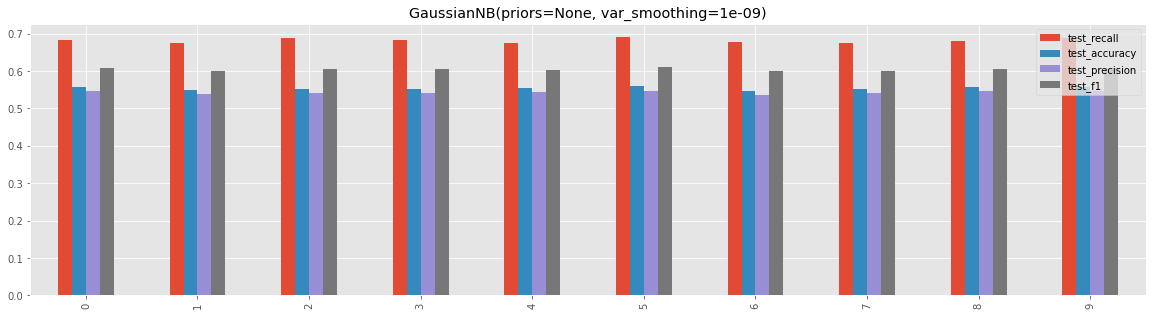

In [ ]:
cv_plot(Smote_nb, X_sm, y_sm)

# Suppor Vector Machines

## Basic Support Vector Machines

In [ ]:
svm_clf = svm.SVC(kernel='sigmoid') # best kernel I found 
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66     16314
           1       0.35      0.35      0.35      8685

    accuracy                           0.55     24999
   macro avg       0.50      0.50      0.50     24999
weighted avg       0.55      0.55      0.55     24999



In [ ]:
svm_clf = svm.SVC(kernel='linear') # best kernel I found 
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     16412
           1       0.00      0.00      0.00      8587

    accuracy                           0.66     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.66      0.52     24999



In [ ]:
svm_clf = svm.SVC(kernel='poly') # best kernel I found 
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     16412
           1       0.00      0.00      0.00      8587

    accuracy                           0.66     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.66      0.52     24999



In [ ]:
svm_clf = svm.SVC(kernel='rbf') # best kernel I found 
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     16412
           1       0.00      0.00      0.00      8587

    accuracy                           0.66     24999
   macro avg       0.33      0.50      0.40     24999
weighted avg       0.43      0.66      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.345399,0.548533,0.347271,0.346332
1,0.347575,0.552000,0.351636,0.349593
2,0.352964,0.545867,0.347086,0.350000
3,0.337182,0.547200,0.343529,0.340326
4,0.343726,0.555867,0.354506,0.349033
5,0.351424,0.554000,0.354839,0.353123
6,0.354119,0.543200,0.344828,0.349411
7,0.355795,0.546606,0.348548,0.352134
8,0.355025,0.547406,0.349110,0.352043
9,0.351559,0.554074,0.354839,0.353191


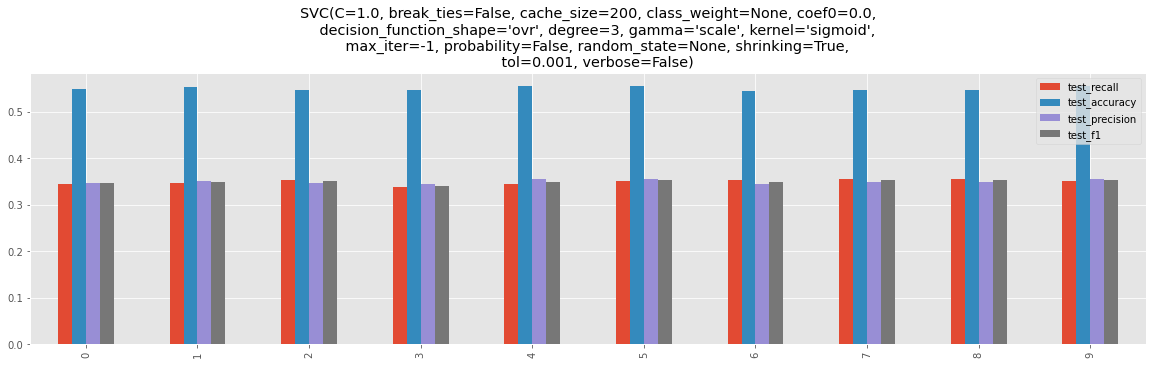

In [ ]:
cv_plot(svm_clf)

## Support Vector Machines with SMOTE

In [ ]:
Smote_svm = svm.SVC(kernel='sigmoid') # best kernel I found 
Smote_svm.fit(X_sm, y_sm)
y_pred = Smote_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57     16314
           1       0.35      0.50      0.41      8685

    accuracy                           0.50     24999
   macro avg       0.50      0.50      0.49     24999
weighted avg       0.55      0.50      0.52     24999



In [ ]:
Smote_svm = svm.SVC(kernel='linear') # best kernel I found 
Smote_svm.fit(X_sm, y_sm)
y_pred = Smote_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.44      0.55     16412
           1       0.38      0.66      0.48      8587

    accuracy                           0.52     24999
   macro avg       0.55      0.55      0.52     24999
weighted avg       0.60      0.52      0.53     24999



In [ ]:
Smote_svm = svm.SVC(kernel='poly') # best kernel I found 
Smote_svm.fit(X_sm, y_sm)
y_pred = Smote_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53     16412
           1       0.38      0.68      0.49      8587

    accuracy                           0.51     24999
   macro avg       0.55      0.55      0.51     24999
weighted avg       0.60      0.51      0.51     24999



In [ ]:
Smote_svm = svm.SVC(kernel='rbf') # best kernel I found 
Smote_svm.fit(X_sm, y_sm)
y_pred = Smote_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.48      0.57     16412
           1       0.39      0.64      0.48      8587

    accuracy                           0.53     24999
   macro avg       0.55      0.56      0.53     24999
weighted avg       0.60      0.53      0.54     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.508329,0.504752,0.504718,0.506517
1,0.502964,0.498135,0.498127,0.500534
2,0.498160,0.502581,0.502578,0.500359
3,0.496679,0.501916,0.501962,0.499307
4,0.503117,0.507435,0.507526,0.505312


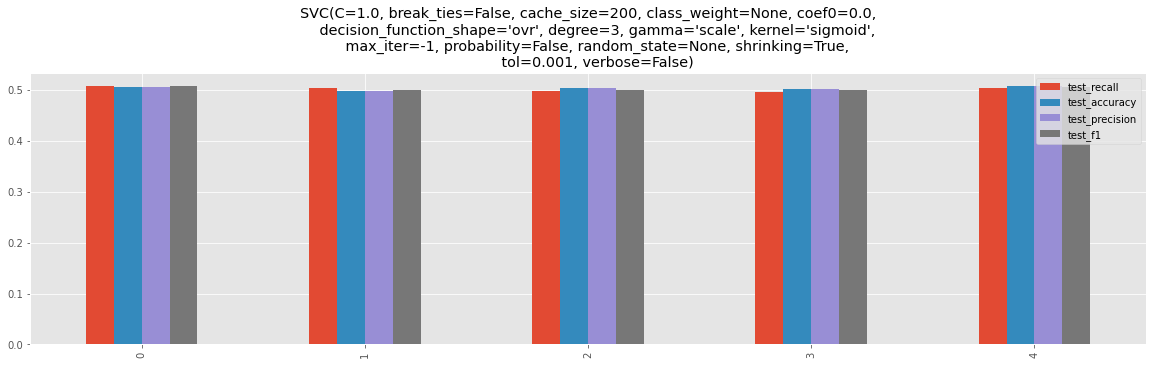

In [ ]:
cv_plot(Smote_svm, X_sm, y_sm, 5)

,test_recall,test_accuracy,test_precision,test_f1
0,0.647522,0.544967,0.537313,0.587292
1,0.651370,0.546119,0.538078,0.589329
2,0.645544,0.546783,0.539046,0.587508
3,0.654778,0.555164,0.546020,0.595474
4,0.648033,0.548010,0.540027,0.589121


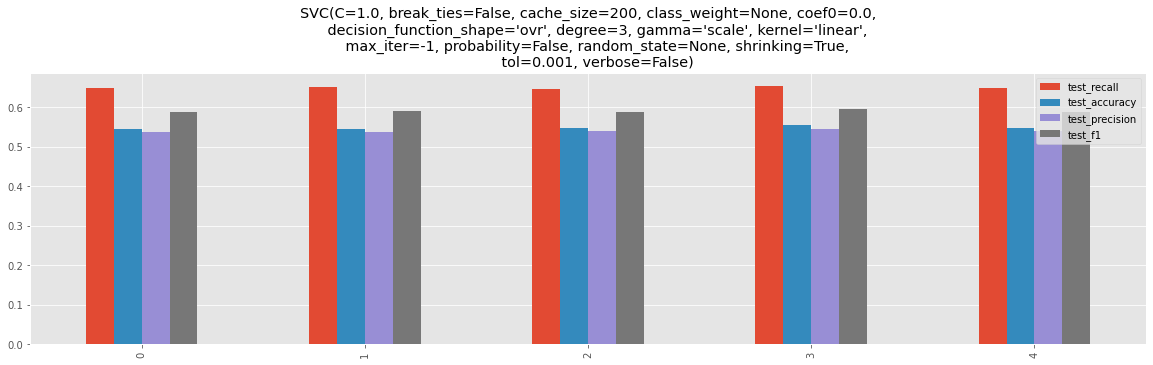

In [ ]:
Smote_svm = svm.SVC(kernel='linear')
cv_plot(Smote_svm, X_sm, y_sm, 5)

,test_recall,test_accuracy,test_precision,test_f1
0,0.667144,0.545733,0.536798,0.594915
1,0.687449,0.548112,0.537607,0.603364
2,0.664554,0.544177,0.535585,0.593140
3,0.675013,0.552353,0.542060,0.601274
4,0.657026,0.544637,0.536465,0.590656


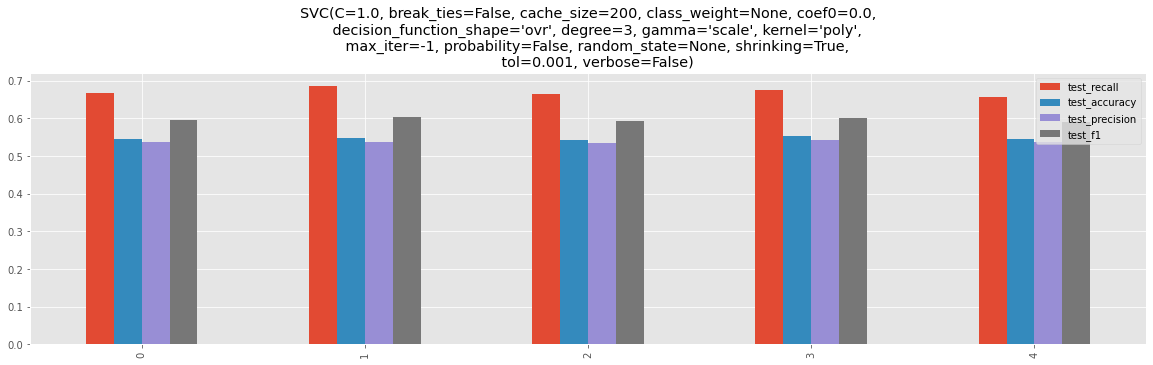

In [ ]:
Smote_svm = svm.SVC(kernel='poly')
cv_plot(Smote_svm, X_sm, y_sm, 5)

,test_recall,test_accuracy,test_precision,test_f1
0,0.636076,0.557026,0.549241,0.589478
1,0.654742,0.560734,0.551101,0.598468
2,0.642886,0.560223,0.551658,0.593788
3,0.621870,0.568297,0.561710,0.590261
4,0.653245,0.563289,0.553660,0.599344


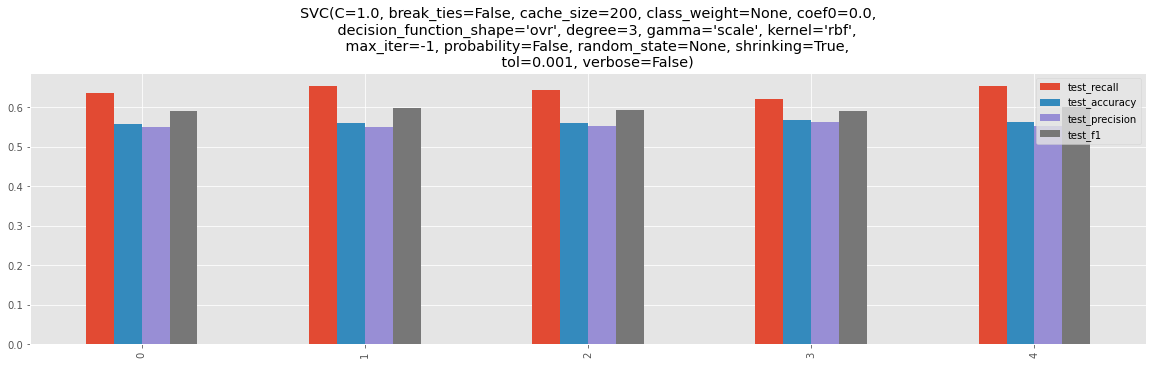

In [ ]:
Smote_svm = svm.SVC(kernel='rbf')
cv_plot(Smote_svm, X_sm, y_sm, 5)

#### Before SMOTE
- only sigmoid kernel is viable
#### After SMOTE
- every kernel is viable
- sigmoid now performs to worst
- poly kernel is now the best

# RandomForrest 

## Basic Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72     16340
           1       0.41      0.29      0.34      8659

    accuracy                           0.61     24999
   macro avg       0.54      0.54      0.53     24999
weighted avg       0.58      0.61      0.59     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.300269,0.609867,0.413884,0.348039
1,0.305267,0.612667,0.419662,0.353439
2,0.286154,0.602800,0.398500,0.333109
3,0.316538,0.611733,0.420327,0.361123
4,0.292308,0.606933,0.406852,0.340197
5,0.298077,0.603867,0.403436,0.342845
6,0.307308,0.610800,0.416797,0.353775
7,0.297308,0.609015,0.411608,0.345243
8,0.303077,0.613682,0.420715,0.352336
9,0.304615,0.610481,0.415748,0.351609


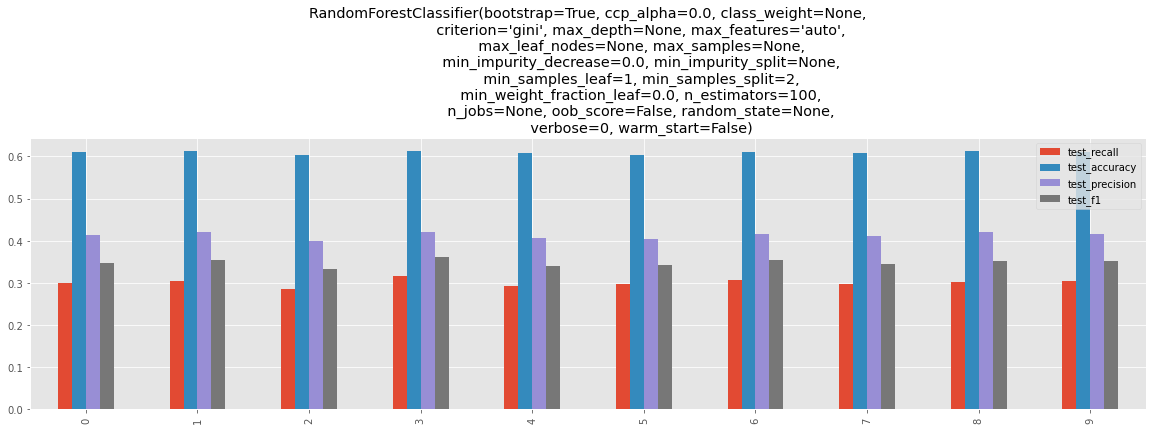

In [ ]:
cv_plot(rf)

## Random Forest with SMOTE

In [ ]:
Smote_rf = RandomForestClassifier()
Smote_rf.fit(X_sm, y_sm)
y_pred = Smote_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     16340
           1       0.40      0.38      0.39      8659

    accuracy                           0.58     24999
   macro avg       0.54      0.54      0.54     24999
weighted avg       0.58      0.58      0.58     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.456939,0.585264,0.614772,0.524233
1,0.443878,0.574957,0.601660,0.510863
2,0.451633,0.585876,0.617467,0.521688
3,0.465306,0.584958,0.611752,0.528573
4,0.454082,0.583835,0.613286,0.521811
5,0.714840,0.704868,0.700820,0.707761
6,0.841804,0.758547,0.721610,0.777087
7,0.836497,0.756812,0.721479,0.774742
8,0.834048,0.763445,0.730817,0.779028
9,0.837518,0.758343,0.722996,0.776054


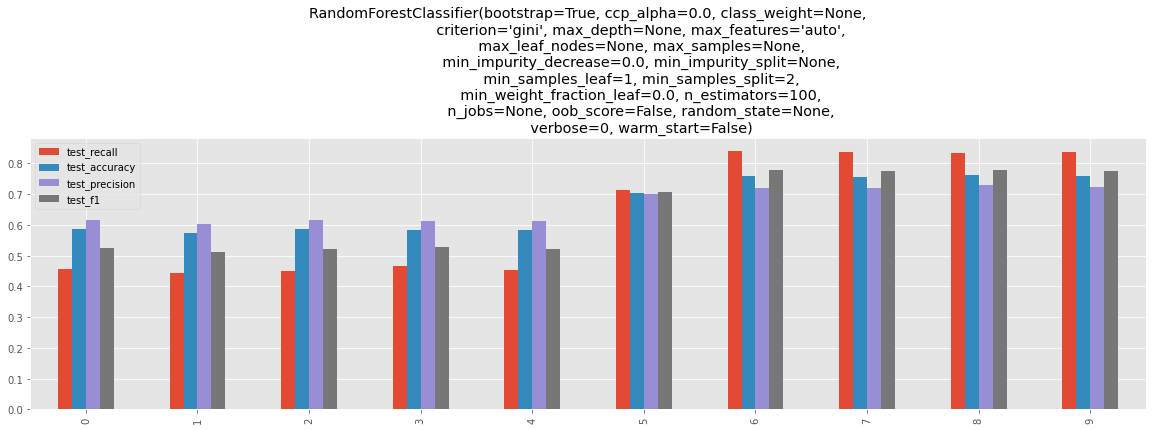

In [ ]:
cv_plot(Smote_rf, X_sm, y_sm)

## Random Forest Feature Importance

In [ ]:
features = ['month', 'week', 'day', 'day_of_week', 'hour']

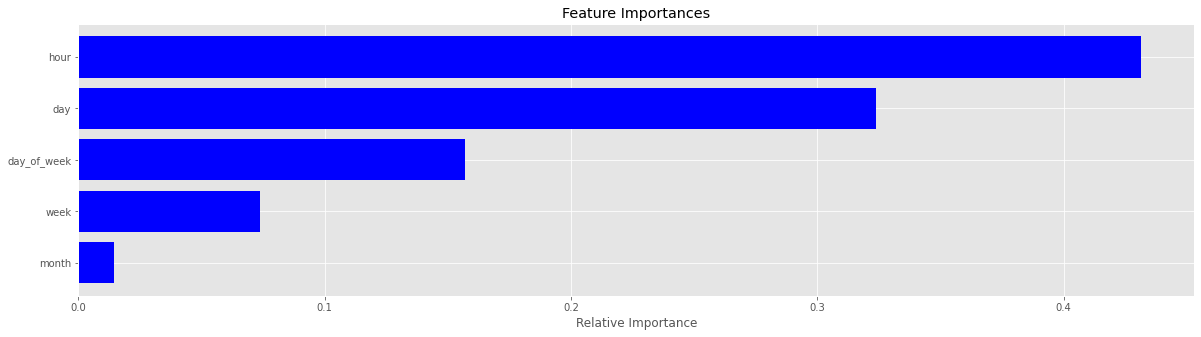

In [ ]:
# features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

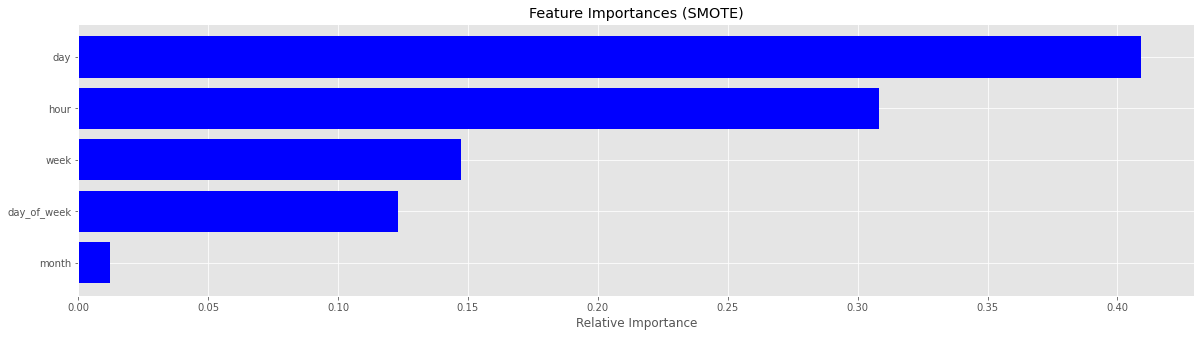

In [ ]:
# features = X.columns
importances = Smote_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances (SMOTE)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Hour feature is the most important for the Random Forest Classifier, which supports the finding in the EDA Notebook.

Suprisingly, the day feature becomes the most important after SMOTE is applied.

# XGBoost

## Basic XGBoost

In [ ]:
xgbc = xgb.XGBClassifier()

In [ ]:
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79     16340
           1       0.63      0.00      0.01      8659

    accuracy                           0.65     24999
   macro avg       0.64      0.50      0.40     24999
weighted avg       0.64      0.65      0.52     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.004614,0.653733,0.600000,0.009157
1,0.002307,0.652133,0.300000,0.004578
2,0.007692,0.652133,0.408163,0.015100
3,0.004231,0.653600,0.550000,0.008397
4,0.003846,0.653067,0.454545,0.007628
5,0.003077,0.654133,0.800000,0.006130
6,0.007308,0.653333,0.500000,0.014405
7,0.002692,0.652487,0.350000,0.005344
8,0.004231,0.653954,0.647059,0.008407
9,0.005769,0.653020,0.468750,0.011398


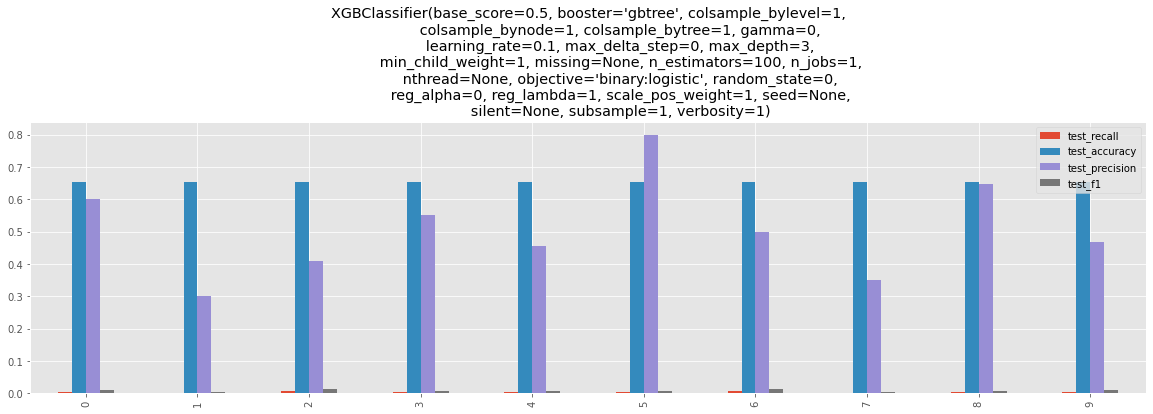

In [ ]:
cv_plot(xgbc)

## XGBoost with SMOTE

In [ ]:
Smote_xgb = xgb.XGBClassifier()
Smote_xgb.fit(X_sm, y_sm)
y_pred = Smote_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64     16340
           1       0.42      0.58      0.49      8659

    accuracy                           0.57     24999
   macro avg       0.57      0.58      0.56     24999
weighted avg       0.61      0.57      0.58     24999



,test_recall,test_accuracy,test_precision,test_f1
0,0.561633,0.568527,0.569536,0.565557
1,0.559388,0.560874,0.561105,0.560245
2,0.572449,0.568221,0.567699,0.570064
3,0.583469,0.571691,0.570090,0.576702
4,0.568980,0.563119,0.562437,0.565689
5,0.629720,0.597714,0.591790,0.610166
6,0.647071,0.597306,0.588454,0.616372
7,0.659522,0.609552,0.599555,0.628110
8,0.658093,0.612614,0.603181,0.629442
9,0.658502,0.613226,0.603781,0.629955


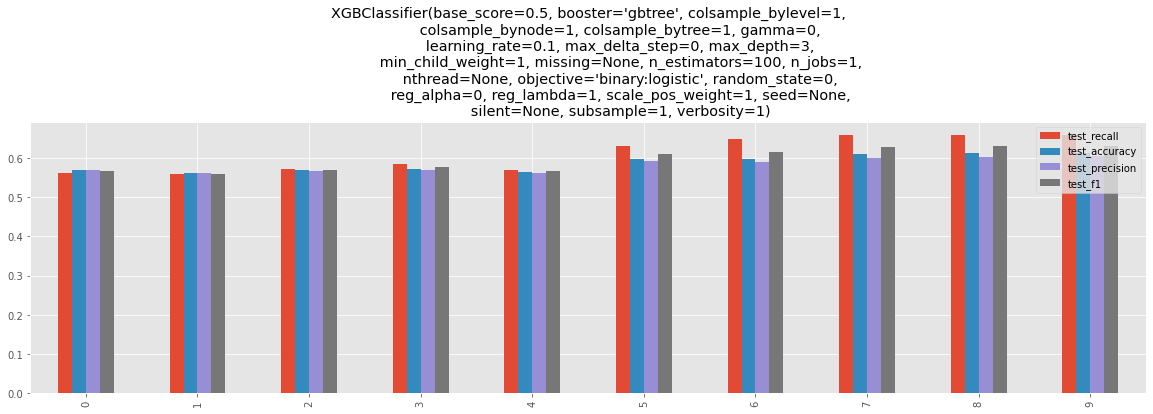

In [ ]:
cv_plot(Smote_xgb, X_sm, y_sm)

## XGBoost Feature Importance

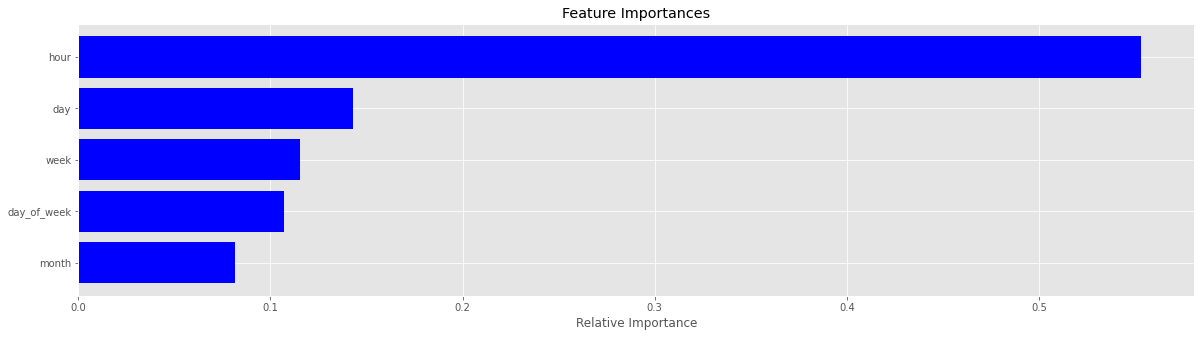

In [ ]:
# features = X.columns
importances = xgbc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

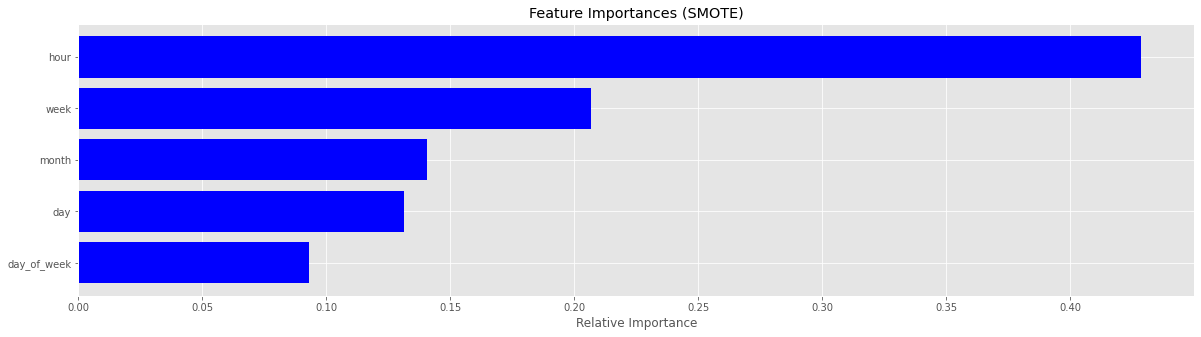

In [ ]:
# features = X.columns
importances = Smote_xgb.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances (SMOTE)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Hour feature is the most important for the XGBoost Classifier, which supports the findnings in the EDA Notebook.

# Grid Search

## Logistic-Regression GridSearch

In [75]:
params = {'penalty' : ['l1', 'l2'],
          'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C': np.logspace(0, 4, 10)}

In [ ]:
log_grid = GridSearchCV(LogisticRegression(), params, cv=10, verbose=2)
log_grid.fit(X_sm, y_sm)

In [77]:
log_grid.best_params_

{'C': 10000.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [78]:
print(classification_report(y_test, log_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.46      0.55     16298
           1       0.38      0.64      0.48      8701

    accuracy                           0.52     24999
   macro avg       0.54      0.55      0.52     24999
weighted avg       0.59      0.52      0.53     24999



No performance boost for logistic regression

In [45]:
print(classification_report(y_test, grid_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.40      0.51     16298
           1       0.38      0.69      0.49      8701

    accuracy                           0.50     24999
   macro avg       0.54      0.54      0.50     24999
weighted avg       0.59      0.50      0.50     24999



In [44]:
grid_svc.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}

## SVC GridSearch
- The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.
- Thus, I will only Grid-Search on a random sample of 10,000 data points from the SMOTE dataset


In [90]:
svm.SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
x = pd.DataFrame(X_sm)
x[5] = y_sm
x

,0,1,2,3,4,5
0,-1.347031,-1.462598,-1.441138,1.536714,1.135946,0
1,-0.757721,-0.854979,-0.833594,1.536714,1.135946,1
2,0.420899,0.292747,0.285058,0.033287,-0.121860,1
3,-0.463066,-0.517412,-0.553931,-0.968997,0.996190,0
4,-0.168411,-0.179846,-0.216407,-1.470139,1.555215,0
...,...,...,...,...,...,...
98069,-1.052376,-1.057519,-1.084326,-0.467855,-0.401372,1
98070,-1.052376,-1.125032,-1.126039,0.534429,-0.541128,1
98071,0.420899,0.562801,0.563925,0.534429,-1.379666,1
98072,-0.168411,-0.232420,-0.232534,0.534429,1.275703,1


In [42]:
x = x.sample(10000)
xs = x[[0,1,2,3,4]]
ys = x[5]

In [43]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly']} 
  
grid_svc = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 2, n_jobs=8)
  
# fitting the model for grid search
grid_svc.fit(xs, ys)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 55.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [92]:
print(classification_report(y_test, grid_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.40      0.51     16298
           1       0.38      0.69      0.49      8701

    accuracy                           0.50     24999
   macro avg       0.54      0.54      0.50     24999
weighted avg       0.59      0.50      0.50     24999



Recall on class 1 minimally improved from 0.68 to 0.69

## Random Forest GridSearch

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,3,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [54]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [50, 75, 100, 125, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [57]:
rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, scoring='recall', verbose=2, n_jobs = -1)
rf_Grid.fit(X_sm, y_sm)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 79.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 110.4min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 116.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [58]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [59]:
print(classification_report(y_test, rf_Grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.44      0.54     16298
           1       0.39      0.68      0.50      8701

    accuracy                           0.52     24999
   macro avg       0.55      0.56      0.52     24999
weighted avg       0.60      0.52      0.53     24999



Recall on 1 increase from 0.38 to 0.68

## XGBoost GridSearch

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


xgb = xgb.XGBClassifier()        

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, verbose=2 )
grid.fit(X_sm, y_sm)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 29.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 47.0min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 69.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 98.8min
[Parallel(n_jobs=4)]: Done 2025 out of 2025 | elapsed: 101.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_

In [ ]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

In [ ]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66     16412
           1       0.42      0.53      0.46      8587

    accuracy                           0.58     24999
   macro avg       0.56      0.57      0.56     24999
weighted avg       0.61      0.58      0.59     24999



Recall on class 1 is lower. Most likely due to poor parameter grid choices for tunning 

# Systematic search for best classification algorithm: Conclusion

All the classification algorithms initially had an `accuracy` of around `0.6` at predicting flight delays. However, when looking at the `classification report` and `cross validation bar plots` it is clear the accuracy score is a poor metric for this problem. The score is only being achieved because most of the alogrithms are predicting the most common class most of the time. 

This is happening due to the class imbalance. 

When considering the high cost of False Negatives in this scenario, the most important metric is `recall`

#### Initial Best Algorithms With Respect To Recall:
- Support Vector Machines (sigmoid)
- Random Forest Classifier

These two algorithms had the best performance. Despite this, their scores are still poor. Further Hyper-parameter tunning may improve the scores; however, this notebook will not do that, due to computing constraints.

#### Best Algorithms after applying SMOTE:
After using SMOTE to deal with the class imbalance leading to the poor scores:

Support Vector Machines(poly) and Naive Bayes:
- Performance increased significantly
- Naive Bayes` rivals SVM performance when it used to be unviable

Random Forest: 
- Initially one of the two best models:
- Recieved an improvment in performance after the class imbalance was addressed, however still lost out to Logistic Regression and Naive Bayes

XGBoost:
- Initially one of the worst models with extremely low recall scores, now beats many of the other models trained on the original dataset

---
<br>
Even after applying SMOTE to the data set, the performance of the models is still poor. There may be a couple key reasons. 

1. Hyper-parameter tunning is needed. Particularly for the ensemble methods (XGBoost, Random Forest) who show potential for higher scores in their cross-validation plots.
- After Hyper-parameter tunning with GridSearchCV:
  - SVC is confirmed to be the best model with a recall score of 0.69
    - Although it isn't to far off drom Naive Bayes classifier with a score of 0.68
2. Another possible conclusion is that not enough information was given or (deduced) to build good models. From the EDA done, the only predictive information I could find was the flight traffic, which I decided to represent by using different time-periods as features.

3. If all the available information was given, and my EDA was appropriate, these results may imply that airlines and airports do a good job at making sure there are no delays. 